In [1]:
import gdsfactory as gf
from gdsfactory.generic_tech import get_generic_pdk
import numpy as np
gf.config.rich_output()
PDK = get_generic_pdk()
PDK.activate()

2023-06-25 21:58:18.338 | INFO     | gdsfactory.config:__init__:204 - LogLevel: INFO
2023-06-25 21:58:20.410 | INFO     | gdsfactory.technology.layer_views:__init__:785 - Importing LayerViews from YAML file: 'C:\\Users\\lkk12\\miniconda3\\envs\\py310\\lib\\site-packages\\gdsfactory\\generic_tech\\layer_views.yaml'.
2023-06-25 21:58:20.421 | INFO     | gdsfactory.pdk:activate:266 - 'generic' PDK is now active


In [2]:
# Honeywell CMOS mask size 21.6 mm by 26 mm
# UCSB in-house mask size 21 mm by 25 mm
maskLH = 21.6e3
maskLV = 26e3
# maskLH = 21e3
# maskHV = 25e3

# layers
layer1 = (1, 0)
layer2 = (2, 0)

# mask design parameters
wg_ring = 11
wg_bus = 7
wg_taper = 7
gap = 5.2
R = 8840

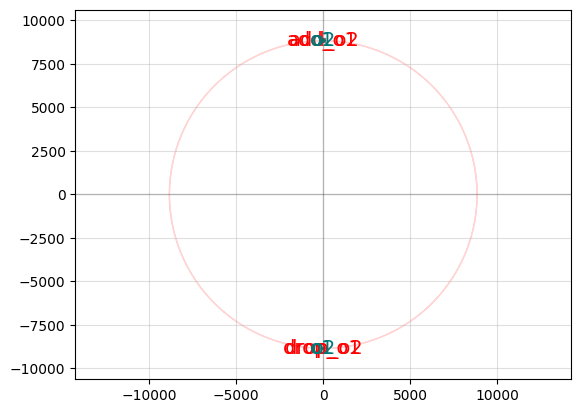

In [3]:
# add-through and add-drop bus-coupled ring resonator
@gf.cell
def bus_ring(radius=1000, wg_ring=6, gap=[2], wg_bus=6, bus_length=100, n_bus=1):
    straight = gf.components.straight
    c = gf.Component("bus_coupled_ring")
    bus = straight(width=wg_bus, length=bus_length, npoints=3)
    ring = gf.components.ring(radius=R, width=wg_ring, 
                              angle_resolution=0.01) # angle_resolution=0.01 is enough
    c.add_ref(ring)
    b1 = c << bus
    b1.move([-bus_length/2, R + gap[0] + (wg_ring + wg_bus)/2])
    c.add_ports(b1.get_ports_list(), prefix="add_")
    
    # n_bus = 2 means add_drop configuration
    if n_bus > 1:
        if len(gap) < 2: gap.append(gap[0])
        b2 = c << bus
        b2.move([-bus_length/2, -(R + gap[1] + (wg_ring + wg_bus)/2)])
        c.add_ports(b2.get_ports_list(), prefix="drop_")
    
    return c

bus_ring(n_bus = 2).plot_matplotlib()

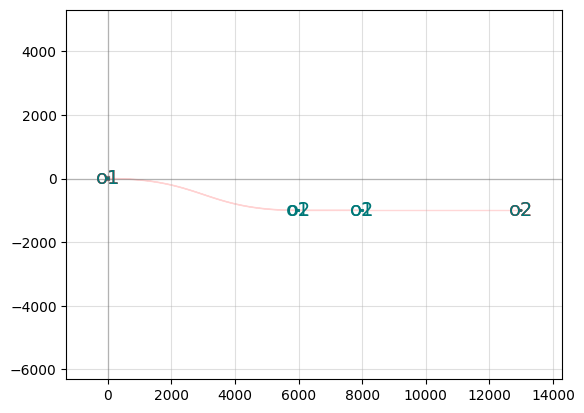

In [4]:
# sbend + taper + output wg
@gf.cell
def sbend_taper(wg=7, wg_taper=2):
    sbend = gf.components.bend_s(width=wg_bus, size=(6e3, -1e3))
    taper = gf.components.taper(2e3, wg, wg_taper)
    sw_out = gf.components.straight(width=wg_taper, length=5e3)

    # Define a map between symbols and (component, input port, output port)
    symbol_to_component = {
        "s": (sbend, "o1", "o2"),
        "t": (taper, "o1", "o2"),
        "o": (sw_out, "o1", "o2"),
        }

    # Generate a sequence
    sequence = "sto"
    c = gf.components.component_sequence(
        sequence=sequence, symbol_to_component=symbol_to_component)
    c.name = "sbend-taper-out"
    return c

sbend_taper().plot_matplotlib()

In [5]:
# dicing dash line
@gf.cell
def dice_line(width = 50, dash = 200, length = 5e3):
    num = np.floor(length/(2*dash))
    c = gf.Component("dice_line")
    sw = gf.components.straight(width=width, length=dash)
    c.add_array(sw, columns=num, rows=1, spacing=[dash*2, 1])
    p0 = c.add_port(name="o1", port=sw.ports["o1"])
    p1 = c.add_port(name="o2", port=sw.ports["o2"], center=[num*2*dash, 0], orientation=-90)
    return c

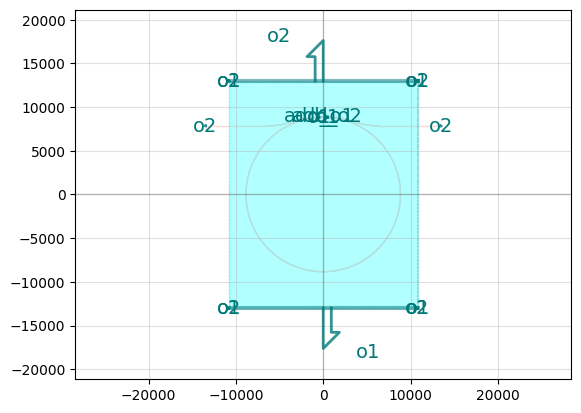

2023-06-25 21:58:22.829 | INFO     | gdsfactory.klive:show:55 - Message from klive: {"version": "0.2.2", "type": "open", "file": "C:\\Users\\lkk12\\AppData\\Local\\Temp\\gdsfactory\\UHQR.gds"}
2023-06-25 21:58:23.054 | INFO     | kfactory.conf:__init__:105 - LogLevel: INFO


AppLayout(children=(Output(layout=Layout(grid_area='footer')), VBox(children=(Button(description='clear annota…

UHQR: uid 1580faa2, ports [], references ['bus_ring_1', 'sbend_taper_1', 'sbend_taper_2', 'straight_1', 'dice_line_1', 'dice_line_2', 'dice_line_3', 'dice_line_4'], 0 polygons


In [6]:
c = gf.Component("UHQR")

# ring resonator layout
ring_res = c << bus_ring(radius=R, wg_ring=wg_ring, gap=[gap], wg_bus=wg_bus, bus_length=1e3, n_bus=1)
sbend1 = c << sbend_taper(wg=wg_bus, wg_taper=wg_taper)
sbend1.mirror_x()
sbend2 = c << sbend_taper(wg=wg_bus, wg_taper=wg_taper)
# sbend3 = c << sbend_taper(wg=wg_bus, wg_taper=wg_taper)
# sbend4 = c << sbend_taper(wg=wg_bus, wg_taper=wg_taper)
# sbend4.mirror_x()

sbend1.connect(port="o1", destination=ring_res.ports["add_o1"])
sbend2.connect(port="o1", destination=ring_res.ports["add_o2"])
# sbend3.connect(port="o1", destination=ring_res.ports["drop_o1"])
# sbend4.connect(port="o1", destination=ring_res.ports["drop_o2"])

# mask area
mask = c << gf.components.straight(width=maskLH, length=maskLV, layer=layer2)
mask.rotate(90)
mask.movey(-maskLV/2)

# dicing lines
dice1 = c << dice_line(length=maskLH)
dice2 = c << dice_line(length=maskLV)
dice3 = c << dice_line(length=maskLH)
dice4 = c << dice_line(length=maskLV)
dice1.move([-maskLH/2, maskLV/2])
dice2.connect(port="o1", destination=dice1.ports["o2"])
dice3.connect(port="o1", destination=dice2.ports["o2"])
dice4.connect(port="o1", destination=dice3.ports["o2"])

# labels and text
# label = c << gf.components.version_stamp(labels=['KAIKAI LIU - UCSB OCPI'], with_qr_code=False, pixel_size=1, text_size=200)
# text1 = c << gf.components.text(text='wg_ring = 11 um wg_bus = 7 um', size=200, position=[0, 1000])
# text2 = c << gf.components.text(text='R = 8840 um gao = 4.5 um', size=200, position=[0, 500])

c.plot_matplotlib()
c

In [7]:
c.write_gds("UHQR.gds")

2023-06-25 21:58:24.760 | INFO     | gdsfactory.component:_write_library:1946 - Wrote to 'UHQR.gds'


WindowsPath('UHQR.gds')